In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.widgets
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def neighbourIndices(nType, rad = 1): #0 = Neumann, 1 = Moore
    indices = []
    if(nType == 0):
        indices = [[i, j] for j in range(-rad, rad + 1) for i in range(abs(j) - rad, rad - abs(j) + 1)]
    
    if(nType == 1):
        indices = [[i, j] for i in range(-rad, rad + 1) for j in range(-rad, rad + 1)]
        
    indices.remove([0,0])
    
    return indices

def isInfected(unit, tauI):
    return (unit >= 1 and unit <tauI)
   
def SIRSmodel(n, tauI, tauR, nType, rad, bType, init = ["rand", 1], nsteps = 100, skip = 1, anim = True):

    fig = plt.figure()
    grid = np.zeros((n,n)) #simulation grid
    plt.colorbar(plt.imshow(grid, cmap="magma", vmin = 0, vmax = tauI+tauR))
    
    nS = np.zeros(nsteps)
    nI = np.zeros(nsteps)
    nR = np.zeros(nsteps)
    
    neighbours = np.zeros((n,n), dtype=object) #stores neighbours
    ims = []; #stores plots
    
    tau0 = tauR + tauI
    halfn = int(n/2)
    
    #initial conditions
    if(init[0] == "rand"):
        initlist = np.random.randint(rad, n - rad, size = (int(init[1]*n), 2))
        for ind in initlist:
            grid[ind[0], ind[1]] = 1
    elif(init[0] == "single"):
        grid[init[1], init[2]] = 1
    elif(init[0] == "corners"):
        grid[rad + 1, rad + 1] = 1
        grid[rad + 1, n - rad - 1] = 1
        grid[n-rad-1, rad + 1] = 1
        grid[n - rad - 1, n - rad - 1]  = 1
            

    #boundary conditions
    if(bType == 'fixed'):
        grid[0:rad, :] = tauI + 1
        grid[n-rad:n, :] = tauI + 1
        grid[:, 0:rad] = tauI + 1
        grid[:, n-rad:n] = tauI + 1
        
    #initial count
    nS[0] = np.count_nonzero(grid == 0)
    nI[0] = sum([np.count_nonzero(grid == i) for i in range(1, tauI)])
    nR[0] = sum([np.count_nonzero(grid == i) for i in range(tauI, tau0)])
    
    infp = 0 #infection probability
    nb = [] #neighbour indices
    
    prev = grid.copy() #store previous value
    
    #calculate neighbours
    for i in range(n):
        for j in range(n):
            neighbours[i, j] = [np.sum([[i, j], neighbour], axis = 0)%n for neighbour in neighbourIndices(nType, rad)]
    

    #evolve loop
    for k in range(1, nsteps):
        nS[k] = nS[k-1]
        nI[k] = nI[k-1]
        nR[k] = nR[k-1]
        
        #evolve
        for i in range(n):
            for j in range(n):
                if(prev[i, j] == 0):
                    infp = [isInfected(prev[ind[0], ind[1]], tauI) for ind in neighbours[i,j]].count(True)/len(neighbours[i,j])
                    if(np.random.random() < infp):
                        grid[i, j] += 1
                        nS[k] -= 1
                        nI[k] += 1
                    else:
                        pass

                elif(prev[i, j] < tau0):
                    grid[i, j] += 1
                    
                    if(grid[i, j] == tauI):
                        nI[k] -= 1
                        nR[k] += 1
                        
                elif(prev[i, j] == tau0):
                    grid[i, j] = 0
                    nR[k] -= 1
                    nS[k] += 1
                    
        if(bType == 'fixed'):
                grid[0:rad, :] = tauI + 1
                grid[n-rad:n, :] = tauI + 1
                grid[:, 0:rad] = tauI + 1
                grid[:, n-rad:n] = tauI + 1
                
        prev = grid.copy()

        if(k%skip == 0 and anim):
            im = plt.imshow(grid, animated=True, vmin = 0, vmax = tau0, cmap = "magma")
            ims.append([im])
    
    if(anim):
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
        ani.save('SIRS.mp4')
    
    return([nS, nI, nR])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


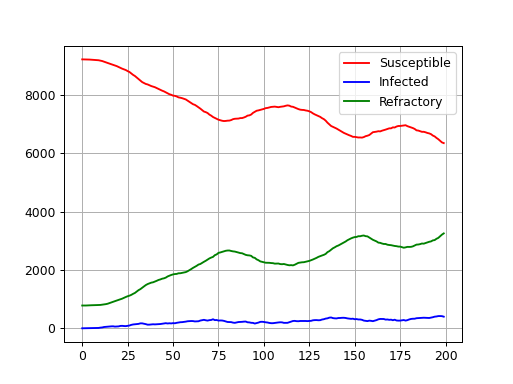

In [3]:
data = SIRSmodel(100, 4, 20, 0, 2, "fixed",["corners"], 200, 1, True)
x = np.arange(len(data[0]))

plt.close("all")
plt.plot(x, data[0], '-', color = 'red')
plt.plot(x, data[1], '-', color = 'blue')
plt.plot(x, data[2], '-', color = 'green')
plt.legend(["Susceptible", "Infected", "Refractory"], loc ="upper right")

plt.grid()
plt.savefig("plot1.png")